# Data collection

In [6]:
import datetime
import json
import os
import mthree
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentEncoder
from qiskit_research.mzm_generation import (
    KitaevHamiltonianExperiment,
    KitaevHamiltonianExperimentParameters,
)
from qiskit_research.mzm_generation.utils import pick_qubit_layout, orbital_combinations
from qiskit.circuit.library import XGate, YGate

In [7]:
# get backend

# uncomment to use hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend_name = 'ibmq_guadalupe'

# Aer simulator backend
# provider = None
# backend_name = "aer_simulator"

ibmqfactory.load_account:WARNING:2022-08-08 09:04:20,273: Credentials are already in use. The existing account in the session will be replaced.


In [6]:
xy4 = [XGate(), YGate(), XGate(), YGate()]
xy8 = [XGate(), YGate(), XGate(), YGate(), YGate(), XGate(), YGate(), XGate()]

In [8]:
# experiment parameters
n_modes = 6
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = list(np.linspace(0.0, 3.0, num=5))
occupied_orbitals_list = list(orbital_combinations(n_modes, threshold=2))
dynamical_decoupling_sequences = None
# dynamical_decoupling_sequences=[xy4]
max_repeats = list(range(1, 11))
shots = 10000
readout_calibration_shots = 10000

# pick qubits
qubits, backend_name, error_score = pick_qubit_layout(n_modes, backend_name, provider)
print(f"Using qubits {qubits}.")

# date
date = datetime.datetime.now().isoformat().replace(":", "")

# create experiment
params = KitaevHamiltonianExperimentParameters(
    timestamp=date,
    backend_name=backend_name,
    qubits=qubits,
    n_modes=n_modes,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    dynamical_decoupling_sequences=dynamical_decoupling_sequences,
    max_repeats=max_repeats,
    seed=11364,
)
experiment = KitaevHamiltonianExperiment(params, provider)

print(f"Total number of circuits: {len(experiment.circuits())}")

Using qubits [12, 13, 14, 11, 8, 9].
Total number of circuits: 3900


In [9]:
%%time

# schedule readout calibration
print("Scheduling readout calibration ...")
mit = mthree.M3Mitigation(experiment.backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots, async_cal=True)

# schedule experiment jobs
print(f"Scheduling experiment ...")
# limit number of circuits per job to avoid timeouts
experiment.backend.configuration().max_experiments = 300
data = experiment.run(shots=shots)
if provider:
    # this only works if the Qiskit Experiments database service is available
    data.save()

# save readout calibration
filename = f"data/readout_calibration/{experiment.backend.name()}/{date}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f"Waiting for readout calibration data ...")
mit.cals_to_file(filename)
print(f"Readout calibration saved.")

Scheduling readout calibration ...
Scheduling experiment ...


Experiment cannot be saved because no experiment service is available. An experiment service is available, for example, when using an IBM Quantum backend.


Waiting for readout calibration data ...
Readout calibration saved.
CPU times: user 4min 17s, sys: 21.9 s, total: 4min 39s
Wall time: 8min 47s


In [10]:
# wait for experiment results
data.block_for_results()

# save data
filename = f"data/{params.filename}.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, "w") as f:
    json.dump(data, f, cls=ExperimentEncoder)

print(params.filename)

2022-08-08T090446.208149_ibmq_guadalupe_n6


In [ ]:
from qiskit_research.mzm_generation.experiment import transpile_circuit

circs = [transpile_circuit(
                circuit,
                experiment.backend,
                initial_layout=list(experiment.physical_qubits),
                pulse_scaling=experiment.params.pulse_scaling,
                pauli_twirling=bool(experiment.params.num_twirled_circuits),
                seed=experiment.rng,
            )
            for circuit in experiment.circuits()]

In [5]:
from qiskit_research.utils.convenience import add_periodic_dynamical_decoupling, add_concatenated_dynamical_decoupling
from qiskit.circuit.library import XGate, YGate

# circs_dd = add_periodic_dynamical_decoupling(circs, experiment.backend, base_dd_sequence=[XGate(), YGate(), XGate(), YGate()], avg_min_delay=2200, max_repeats=5, add_pulse_cals=True)
# circs_dd = [add_periodic_dynamical_decoupling(circ, experiment.backend, max_repeats=circ.metadata["params"].max_repeats) for circ in circs]
circs_dd = [add_concatenated_dynamical_decoupling(circ, experiment.backend, dd_sequences=[XGate(), YGate(), XGate(), YGate()], concatenates=4, add_pulse_cals=True) for circ in circs]

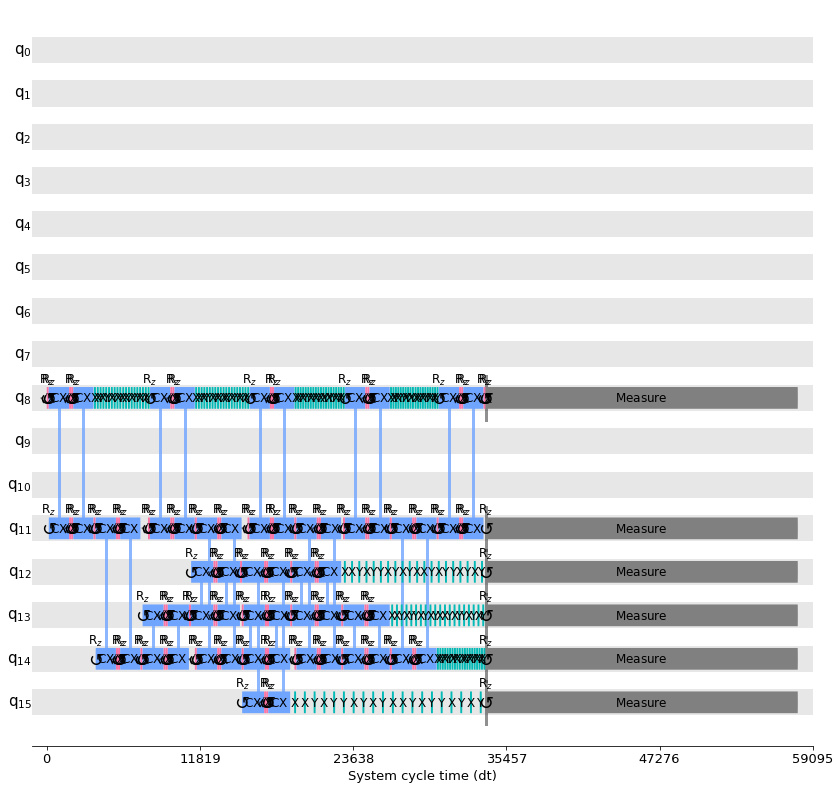

In [6]:
from qiskit.visualization import timeline_drawer
timeline_drawer(circs_dd[0])

In [3]:
l = None

In [7]:
type(l)

list

In [8]:
type(l[0]) == list

False

In [4]:
l is None

True